# importing libraries

In [95]:
import pandas as pd
import numpy as np

In [15]:
import joblib

In [17]:
import sklearn

In [19]:
from sklearn.impute import SimpleImputer

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [23]:
from sklearn.compose import ColumnTransformer

In [25]:
from sklearn.pipeline import Pipeline

In [21]:
pip install feature-engine


Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from feature_engine.datetime import DatetimeFeatures
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

In [39]:
import matplotlib.pyplot as plt

display preferences

In [174]:
pd.set_option("display.max_columns",None)

In [176]:
sklearn.set_config(transform_output="default")

read data

In [178]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
val_df=pd.read_csv("data/val.csv")

data split

In [180]:
def split_data(data):
    X=data.drop(columns="price")
    
    y=data.price.copy()
    return (X,y)

In [182]:
X_train,y_train = split_data(train_df)

In [184]:
X_train.shape

(640, 9)

In [53]:
y_train.shape

(640,)

In [186]:
X_test,y_test = split_data(test_df)

In [188]:
X_val,y_val = split_data(val_df)

In [59]:
X_val.shape

(160, 9)

In [61]:
X_test.shape

(200, 9)

In [63]:
X_train.info

<bound method DataFrame.info of                airline date_of_journey    source destination  dep_time  \
0          Jet Airways      2019-06-21    Mumbai   Hyderabad  10:20:00   
1            Air India      2019-05-18     Delhi      Cochin  09:00:00   
2            Air India      2019-06-12   Kolkata    Banglore  09:10:00   
3              Vistara      2019-04-01   Kolkata    Banglore  20:20:00   
4              Vistara      2019-06-06   Kolkata    Banglore  17:00:00   
..                 ...             ...       ...         ...       ...   
635           Air Asia      2019-04-12  Banglore       Delhi  04:55:00   
636        Jet Airways      2019-05-09   Kolkata    Banglore  09:35:00   
637             Indigo      2019-05-15  Banglore       Delhi  06:05:00   
638  Multiple Carriers      2019-05-15     Delhi      Cochin  08:45:00   
639        Jet Airways      2019-05-21   Kolkata    Banglore  20:00:00   

    arrival_time  duration  total_stops              additional_info  
0       

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [190]:
dt_col=["date_of_journey","dep_time","arrival_time"]



In [192]:
num_col=["duration","total_stops"]

In [194]:
cat_col=[col for col in X_train.columns if (col not in dt_col) and (col not in num_col)]

In [196]:
cat_col

['airline', 'source', 'destination', 'additional_info']

In [198]:
num_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"],format="mixed")),
    ("scaler",StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour","minute"],format="mixed")),
    ("scaler", StandardScaler())
])


In [200]:
preprocessor = ColumnTransformer(transformers=[
    ("num",num_pipe, num_col),
    ("cat",cat_pipe,cat_col),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time",time_transformer,["dep_time","arrival_time"])
])

In [202]:
preprocessor.fit_transform(X_train).shape

(640, 33)

In [204]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

In [206]:
data = pd.concat([train_df,val_df],axis=0)
X_data,y_data=split_data(data)
print(X_data.shape,y_data.shape)

(800, 9) (800,)


In [208]:
def plot_curves(sizes,mean_scores,std_scores,label,ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )
    ax.fill_between(
        x=sizes,
        y1=mean_scores-std_scores,
        y2=mean_scores+std_scores,
        alpha=0.5
    )

In [210]:
def plot_learning_curves(name,algorithm,figsize=(12,4)):
    model=Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])
    train_sizes,train_scores,test_scores=learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42,
        
    )
    mean_train_scores=np.mean(train_scores,axis=1)
    std_train_scores=np.std(train_scores,axis=1)
    train_score=f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores=np.mean(test_scores,axis=1)
    std_test_scores=np.std(test_scores,axis=1)
    test_score=f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig,ax=plt.subplots(figsize=figsize)
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )
    ax.set(xlabel="Training set sizes",ylabel="R-square",title=name)
    ax.legend(loc="lower right")
    plt.show()

    


    

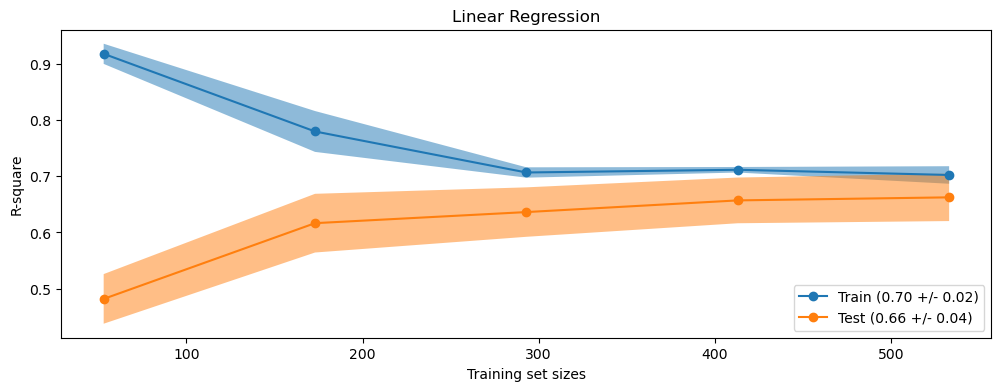

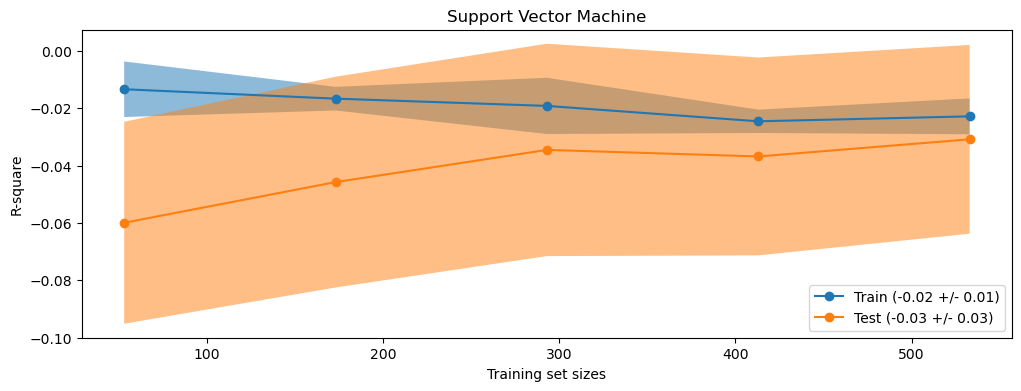

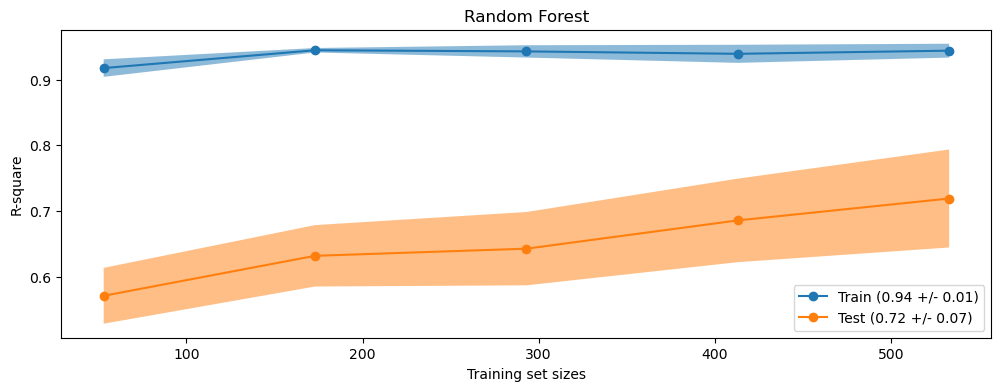

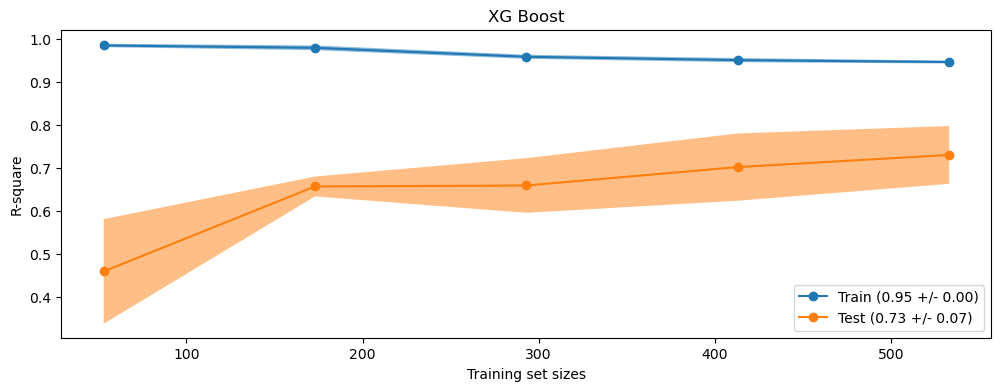

In [212]:
for name,alg in algorithms.items():
    plot_learning_curves(name,alg)


In [214]:
model=Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10))
])


In [218]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [226]:
def evaluate_model(X,y):
    y_pred=model.predict(X)
    return r2_score(y,y_pred)

In [228]:
print(f"R2-score on training data is {evaluate_model(X_data,y_data)}")

R2-score on training data is 0.9589602560811484


In [230]:
print(f"R2-score on testing data is {evaluate_model(X_test,y_test)}")

R2-score on testing data is 0.7349645779378029


In [234]:
joblib.dump(model,'model.joblib')


['model.joblib']

In [236]:
saved_model=joblib.load('model.joblib')

In [244]:
y_pred=saved_model.predict(X_test)

In [248]:
r2_score(y_test,y_pred)

0.7349645779378029